# Tutorial on self-normalizing networks on the MNIST data set: multi-layer perceptrons

*Author:* Kajetan Schweighofer, 2021

In [11]:
import os
import numpy as np
from tqdm.autonotebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from utils.act_fn import MLP

device = "cuda" if torch.cuda.is_available() else "cpu"



In [12]:
x_dim = 50
size = 100000


rand_freq = np.random.uniform(0.1, 2, x_dim)
rand_phase = np.random.uniform(0, 2*np.pi, x_dim)


x_data = np.random.randn(size, x_dim)
y = np.zeros(size)
for i in range(size):
    y[i] = np.sum(np.cos(x_data[i]*rand_freq + rand_phase))



class SynSinDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sample = self.x_data[idx]
        label = self.y_data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label


dataset = SynSinDataset(x_data, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


batch_size = 128

# val_inds = rng.choice(np.arange(len(self.train)), size=len(self.train)//6, replace=False)
# train_inds = np.delete(np.arange(len(self.train)), val_inds)

# self.trainloader = DataLoader(Subset(self.train, indices=train_inds),
#                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
# self.valloader = DataLoader(Subset(self.train, indices=val_inds),
#                     batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
# self.testloader = DataLoader(self.test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Functions

### Model

### Accuracy metric

In [17]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)




### Training / Evaluation methods

In [ ]:
class MNIST_Experiment:

    def __init__(self, batch_size: int = 128, num_workers: int = 4):

        self.batch_size = batch_size
        self.num_workers = num_workers 
        
        path = os.path.join(".", "dataset", "mnist")
        os.makedirs(path, exist_ok=True)

        # convert PIL image to tensor and normalize
        transform = transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        self.train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
        self.test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)
        rng = np.random.default_rng(seed=42)
        val_inds = rng.choice(np.arange(len(self.train)), size=len(self.train)//6, replace=False)
        train_inds = np.delete(np.arange(len(self.train)), val_inds)

        self.trainloader = DataLoader(Subset(self.train, indices=train_inds),
                                batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
        self.valloader = DataLoader(Subset(self.train, indices=val_inds),
                            batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
        self.testloader = DataLoader(self.test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)



    def _forward(self, network: nn.Module, data: DataLoader, metric: callable):

        for x, y in data:
            x = x.to(next(network.parameters()).device)
            # y_hat = network.forward(x)
            y_hat = network.forward(x).cpu()
            loss = metric(y_hat, y)
            yield loss

    @torch.enable_grad()
    def update(self, network: nn.Module, data: DataLoader, loss: nn.Module,
            opt: torch.optim.Optimizer) -> list:

        network.train()

        errs = []
        for err in self._forward(network, data, loss):
            errs.append(err.item())
            opt.zero_grad()
            try:
                err.backward()
                opt.step()
            except:
                print('error in update step')
        return errs

    @torch.no_grad()
    def evaluate(self, network: nn.Module, data: DataLoader, metric: callable) -> float:

        network.eval()

        performance = []
        for p in self._forward(network, data, metric):
            p = np.array(p)
            performance.append(p.item())
        return np.mean(performance).item()


    def fit(self, network: nn.Module, epochs: int, lr: float):
        optimizer = torch.optim.SGD(params=network.parameters(), lr=lr, weight_decay=1e-2)
        # optimizer = torch.optim.AdamW(params=network.parameters(), lr=lr, weight_decay=1e-3)
        ce = nn.CrossEntropyLoss()
        accuracy = Accuracy()

        train_losses, val_losses, accuracies = [], [], []

        # performance before training
        val_losses.append(self.evaluate(network=network, data=self.valloader, metric=ce))

        pbar = tqdm(range(epochs))
        for ep in pbar:
            # update network
            tl = self.update(network=network, data=self.trainloader, loss=ce, opt=optimizer)
            train_losses.extend(tl)
            vl = self.evaluate(network=network, data=self.valloader, metric=ce)
            val_losses.append(vl)
            ac = self.evaluate(network=network, data=self.valloader, metric=accuracy)

            if len(accuracies) == 0 or ac > max(accuracies):
                # here we would store the model on disc for early stopping
                # best_model = copy.deepcopy(network)
                best_model = network

            accuracies.append(ac)

            tqdm.write(
                f"Epoch {ep+1}: "
                f"train loss: {round(np.mean(tl), 4):.4f}, "
                f"val loss: {round(vl, 4):.4f}, "
                f"accuracy: {round(ac * 100, 2):.2f}%"
            )
            # print(f"train loss: {round(np.mean(tl), 4):.4f}, "
            #       f"val loss: {round(vl, 4):.4f}, "
            #       f"accuracy: {round(ac * 100, 2):.2f}%")

            pbar.set_description_str(desc=f"Epoch {ep+1}")

        # evaluate on best model obtained throughout training
        acc = self.evaluate(network=best_model, data=self.testloader, metric=accuracy)

        print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

        return [train_losses, val_losses, accuracies, acc]

In [ ]:
class Synthetic_Experiment:

    def __init__(self, batch_size: int = 128, num_workers: int = 4, x_dim: int = 50, data_size: int = 100000):

        self.batch_size = batch_size
        self.num_workers = num_workers 
        self.x_dim = x_dim
        self.data_size = data_size
        rng = np.random.default_rng(seed=42)

        self.rand_freq = np.random.uniform(0.1, 2, self.x_dim, seed=rng)
        self.rand_phase = np.random.uniform(0, 2*np.pi, self.x_dim, seed=rng)


        self.x_data = np.random.randn(self.data_size, self.x_dim)
        y = np.zeros(self.data_size)
        for i in range(self.data_size):
            y[i] = np.sum(np.cos(self.x_data[i]*self.rand_freq + self.rand_phase))

        dataset = SynSinDataset(self.x_data, y)

        train_size = int(0.7 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
        self.train = train_dataset
        self.test = test_dataset
        self.val = val_dataset

        self.trainloader = DataLoader(self.train, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
        self.valloader = DataLoader(self.val, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
        self.testloader = DataLoader(self.test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)



    def _forward(self, network: nn.Module, data: DataLoader, metric: callable):

        for x, y in data:
            print(x.dtype)
            x = x.to(next(network.parameters()).device)
            # y_hat = network.forward(x)
            y_hat = network.forward(x).cpu()
            loss = metric(y_hat, y)
            yield loss

    @torch.enable_grad()
    def update(self, network: nn.Module, data: DataLoader, loss: nn.Module,
            opt: torch.optim.Optimizer) -> list:

        network.train()

        errs = []
        for err in self._forward(network, data, loss):
            errs.append(err.item())
            opt.zero_grad()
            try:
                err.backward()
                opt.step()
            except:
                print('error in update step')
        return errs

    @torch.no_grad()
    def evaluate(self, network: nn.Module, data: DataLoader, metric: callable) -> float:

        network.eval()

        performance = []
        for p in self._forward(network, data, metric):
            p = np.array(p)
            performance.append(p.item())
        return np.mean(performance).item()


    def fit(self, network: nn.Module, epochs: int, lr: float):
        optimizer = torch.optim.SGD(params=network.parameters(), lr=lr, weight_decay=1e-2)
        # optimizer = torch.optim.AdamW(params=network.parameters(), lr=lr, weight_decay=1e-3)
        mse = nn.MSELoss()
        # accuracy = Accuracy()

        train_losses, val_losses, accuracies = [], [], []

        # performance before training
        val_losses.append(self.evaluate(network=network, data=self.valloader, metric=mse))

        pbar = tqdm(range(epochs))
        for ep in pbar:
            # update network
            tl = self.update(network=network, data=self.trainloader, loss=mse, opt=optimizer)
            train_losses.extend(tl)
            vl = self.evaluate(network=network, data=self.valloader, metric=mse)
            val_losses.append(vl)
            ac = self.evaluate(network=network, data=self.valloader, metric=mse)

            if len(accuracies) == 0 or ac > max(accuracies):
                # here we would store the model on disc for early stopping
                # best_model = copy.deepcopy(network)
                best_model = network

            accuracies.append(ac)

            tqdm.write(
                f"Epoch {ep+1}: "
                f"train loss: {round(np.mean(tl), 4):.4f}, "
                f"val loss: {round(vl, 4):.4f}, "
                f"accuracy: {round(ac * 100, 2):.2f}%"
            )
            # print(f"train loss: {round(np.mean(tl), 4):.4f}, "
            #       f"val loss: {round(vl, 4):.4f}, "
            #       f"accuracy: {round(ac * 100, 2):.2f}%")

            pbar.set_description_str(desc=f"Epoch {ep+1}")

        # evaluate on best model obtained throughout training
        acc = self.evaluate(network=best_model, data=self.testloader, metric=accuracy)

        print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

        return [train_losses, val_losses, accuracies, acc]

## Training

### Hyperparameters

In [19]:
epochs = 20
# lr = 1e-3
lr = 1e-1
batch_size = 128
num_workers = 4
p_drop = 0.2

all_results = []

### Create Dataloaders

In [20]:
# # obtain validation set (1/6 of train data to be equal to size of test data)
# rng = np.random.default_rng(seed=42)
# val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
# train_inds = np.delete(np.arange(len(train)), val_inds)

# trainloader = DataLoader(Subset(train, indices=train_inds),
#                          batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
# valloader = DataLoader(Subset(train, indices=val_inds),
#                        batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
# testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [21]:
# exp training
exp_list = ["reu", "relu"]

for exp_name in exp_list:
    network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn=exp_name, use_dropout=True, use_layernorm=True, use_sparse=False)
    network = network.to(device)
    exp = Synthetic_Experiment(batch_size=batch_size, num_workers=num_workers)
    exp_results = exp.fit(network, epochs, lr)
    exp_results.append(exp_name.upper())
    all_results.append(exp_results)

# # network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="linear").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu", use_dropout=True, use_layernorm=True, use_sparse=False)
# network = network.to(device)
# exp = MNIST_Experiment(batch_size=batch_size, num_workers=num_workers)
# reu_results = exp.fit(network, epochs, lr)
# reu_results.append("REU")
# all_results.append(reu_results)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

Epoch 1:   5%|▌         | 1/20 [00:01<00:29,  1.53s/it]

Epoch 1: train loss: 0.4838, val loss: 0.4046, accuracy: 95.19%


Epoch 2:  10%|█         | 2/20 [00:03<00:28,  1.56s/it]

Epoch 2: train loss: 0.3777, val loss: 0.3673, accuracy: 96.51%


Epoch 3:  15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

Epoch 3: train loss: 0.3656, val loss: 0.4092, accuracy: 94.91%


Epoch 4:  20%|██        | 4/20 [00:06<00:25,  1.57s/it]

Epoch 4: train loss: 0.3640, val loss: 0.3671, accuracy: 96.58%


Epoch 5:  25%|██▌       | 5/20 [00:07<00:23,  1.58s/it]

Epoch 5: train loss: 0.3604, val loss: 0.3989, accuracy: 95.33%


Epoch 6:  30%|███       | 6/20 [00:09<00:22,  1.57s/it]

Epoch 6: train loss: 0.3595, val loss: 0.4541, accuracy: 92.42%


Epoch 7:  35%|███▌      | 7/20 [00:10<00:20,  1.56s/it]

Epoch 7: train loss: 0.3592, val loss: 0.3680, accuracy: 96.40%


Epoch 8:  40%|████      | 8/20 [00:12<00:18,  1.56s/it]

Epoch 8: train loss: 0.3572, val loss: 0.3595, accuracy: 96.88%


Epoch 9:  45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

Epoch 9: train loss: 0.3562, val loss: 0.4119, accuracy: 94.81%


Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.57s/it]

Epoch 10: train loss: 0.3593, val loss: 0.3647, accuracy: 96.76%


Epoch 11:  55%|█████▌    | 11/20 [00:17<00:14,  1.57s/it]

Epoch 11: train loss: 0.3542, val loss: 0.3894, accuracy: 95.66%


Epoch 12:  60%|██████    | 12/20 [00:18<00:12,  1.57s/it]

Epoch 12: train loss: 0.3593, val loss: 0.3486, accuracy: 97.22%


Epoch 13:  65%|██████▌   | 13/20 [00:20<00:10,  1.56s/it]

Epoch 13: train loss: 0.3518, val loss: 0.3673, accuracy: 96.56%


Epoch 14:  70%|███████   | 14/20 [00:21<00:09,  1.57s/it]

Epoch 14: train loss: 0.3605, val loss: 0.3826, accuracy: 96.00%


Epoch 15:  75%|███████▌  | 15/20 [00:23<00:07,  1.58s/it]

Epoch 15: train loss: 0.3553, val loss: 0.3726, accuracy: 96.23%


Epoch 16:  80%|████████  | 16/20 [00:25<00:06,  1.57s/it]

Epoch 16: train loss: 0.3568, val loss: 0.3890, accuracy: 95.53%


Epoch 17:  85%|████████▌ | 17/20 [00:26<00:04,  1.58s/it]

Epoch 17: train loss: 0.3545, val loss: 0.3622, accuracy: 96.65%


Epoch 18:  90%|█████████ | 18/20 [00:28<00:03,  1.60s/it]

Epoch 18: train loss: 0.3574, val loss: 0.3667, accuracy: 96.51%


Epoch 19:  95%|█████████▌| 19/20 [00:29<00:01,  1.59s/it]

Epoch 19: train loss: 0.3575, val loss: 0.4188, accuracy: 94.35%


Epoch 20: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]

Epoch 20: train loss: 0.3563, val loss: 0.3720, accuracy: 96.27%


Final accuracy on testset: 96.50%


In [ ]:




# network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="square").to(device)
# LN_tl, LN_vl, LN_accs, LN_acc = fit(network, trainloader, valloader, testloader, epochs, lr)
# ReLU training

# 28x28 = 784 input images for 10 classes
# network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
# rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

# # SELU training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="selu").to(device)
# stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

# # ELU training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="elu").to(device)
# elutl, eluvl, eluaccs, eluacc = fit(network, trainloader, valloader, testloader, epochs, lr)

# # exp training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# softtl, softvl, softaccs, softacc = fit(network, trainloader, valloader, testloader, epochs, lr)

# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)


Epoch 1:   5%|▌         | 1/20 [00:01<00:29,  1.56s/it]

Epoch 1: train loss: 0.5439, val loss: 0.4262, accuracy: 95.35%


Epoch 2:  10%|█         | 2/20 [00:03<00:28,  1.57s/it]

Epoch 2: train loss: 0.4148, val loss: 0.4012, accuracy: 95.84%


Epoch 3:  15%|█▌        | 3/20 [00:04<00:27,  1.60s/it]

Epoch 3: train loss: 0.4037, val loss: 0.3856, accuracy: 96.45%


Epoch 4:  20%|██        | 4/20 [00:06<00:25,  1.60s/it]

Epoch 4: train loss: 0.3937, val loss: 0.4781, accuracy: 93.15%


Epoch 5:  25%|██▌       | 5/20 [00:07<00:23,  1.60s/it]

Epoch 5: train loss: 0.3877, val loss: 1.3107, accuracy: 52.52%


Epoch 6:  30%|███       | 6/20 [00:09<00:22,  1.58s/it]

Epoch 6: train loss: 0.3931, val loss: 0.5764, accuracy: 88.81%


Epoch 7:  35%|███▌      | 7/20 [00:11<00:20,  1.58s/it]

Epoch 7: train loss: 0.3777, val loss: 0.4001, accuracy: 95.52%


Epoch 8:  40%|████      | 8/20 [00:12<00:18,  1.58s/it]

Epoch 8: train loss: 0.3854, val loss: 0.4110, accuracy: 95.48%


Epoch 9:  45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

Epoch 9: train loss: 0.3775, val loss: 0.3596, accuracy: 96.88%


Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.57s/it]

Epoch 10: train loss: 0.3832, val loss: 0.3904, accuracy: 96.14%


Epoch 11:  55%|█████▌    | 11/20 [00:17<00:14,  1.57s/it]

Epoch 11: train loss: 0.3759, val loss: 0.4074, accuracy: 95.08%


Epoch 12:  60%|██████    | 12/20 [00:18<00:12,  1.57s/it]

Epoch 12: train loss: 0.3738, val loss: 0.3691, accuracy: 96.74%


Epoch 13:  65%|██████▌   | 13/20 [00:20<00:10,  1.57s/it]

Epoch 13: train loss: 0.3789, val loss: 0.4853, accuracy: 91.94%


Epoch 14:  70%|███████   | 14/20 [00:22<00:09,  1.57s/it]

Epoch 14: train loss: 0.3766, val loss: 0.3725, accuracy: 96.50%


Epoch 15:  75%|███████▌  | 15/20 [00:23<00:07,  1.56s/it]

Epoch 15: train loss: 0.3736, val loss: 0.4340, accuracy: 94.21%


Epoch 16:  80%|████████  | 16/20 [00:25<00:06,  1.57s/it]

Epoch 16: train loss: 0.3775, val loss: 0.3813, accuracy: 96.14%


Epoch 17:  85%|████████▌ | 17/20 [00:26<00:04,  1.57s/it]

Epoch 17: train loss: 0.3745, val loss: 0.3988, accuracy: 95.59%


Epoch 18:  90%|█████████ | 18/20 [00:28<00:03,  1.57s/it]

Epoch 18: train loss: 0.3731, val loss: 0.3663, accuracy: 96.72%


Epoch 19:  95%|█████████▌| 19/20 [00:29<00:01,  1.57s/it]

Epoch 19: train loss: 0.3743, val loss: 0.4003, accuracy: 94.85%


Epoch 20: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

Epoch 20: train loss: 0.3724, val loss: 0.3787, accuracy: 96.07%


Final accuracy on testset: 96.45%


### Plot results

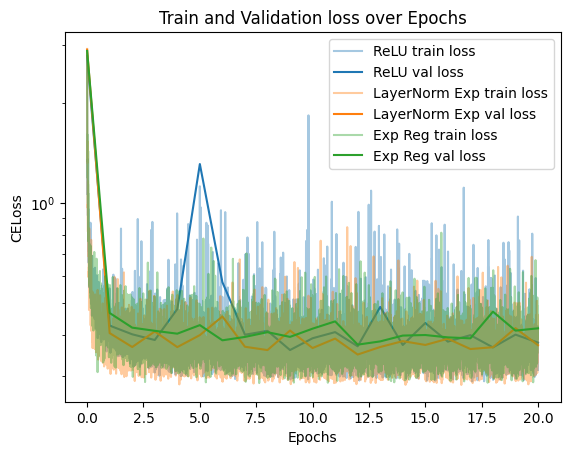

In [ ]:
plt.figure()

for i in range(len(all_results)):
    tl, vl, accs, acc, name = all_results[i]
    plt.plot(np.asarray(range(len(tl))) / len(exp.trainloader), tl, alpha=0.4, label=f"{name} train loss")
    plt.plot(range(len(vl)), vl, label=f"{name} val loss", color=f"C{i}")
    
# plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
# plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
# plt.plot(np.asarray(range(len(LN_tl))) / len(trainloader), LN_tl, alpha=0.4, label="LayerNorm Exp train loss")
# plt.plot(range(len(LN_vl)), LN_vl, color="C1", label="LayerNorm Exp val loss")
# plt.plot(np.asarray(range(len(llt))) / len(trainloader), llt, alpha=0.4, label="Exp Reg train loss")
# plt.plot(range(len(llvl)), llvl, color="C2", label="Exp Reg val loss")
# # plt.plot(np.asarray(range(len(softtl))) / len(trainloader), softtl, alpha=0.4, label="Exp train loss")
# # plt.plot(range(len(softvl)), softvl, color="C2", label="Exp val loss")
# # plt.plot(np.asarray(range(len(elutl))) / len(trainloader), elutl, alpha=0.4, label="ELU train loss")
# # plt.plot(range(len(eluvl)), eluvl, color="C3", label="ELU val loss")
# # plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
# # plt.plot(range(len(svl)), svl, color="C4", label="SELU val loss")


plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

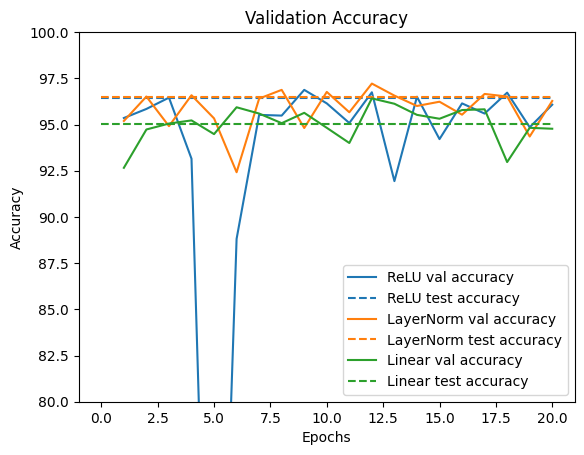

In [18]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(LN_accs)+1), [a*100 for a in LN_accs], label="LayerNorm val accuracy")
plt.hlines(y=LN_acc*100, xmin=0, xmax=len(LN_accs), colors="C1", linestyles="dashed", label="LayerNorm test accuracy")
plt.plot(range(1, len(llaccs)+1), [a*100 for a in llaccs], label="Linear val accuracy")
plt.hlines(y=llacc*100, xmin=0, xmax=len(llaccs), colors="C2", linestyles="dashed", label="Linear test accuracy")
# plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
# plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
# plt.plot(range(1, len(softaccs)+1), [a*100 for a in softaccs], label="Exp val accuracy")
# plt.hlines(y=softacc*100, xmin=0, xmax=len(softaccs), colors="C2", linestyles="dashed", label="Exp test accuracy")
# plt.plot(range(1, len(eluaccs)+1), [a*100 for a in eluaccs], label="ELU val accuracy")
# plt.hlines(y=eluacc*100, xmin=0, xmax=len(eluaccs), colors="C3", linestyles="dashed", label="ELU test accuracy")

plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(80, 100)
plt.legend()
plt.show()